**Preprocessing BLAST data**

In [1]:
import pandas as pd
import os
from tqdm import tqdm

def merge_blast_results(file_path1, file_path2):
    df1 = process_blast_file(file_path1)
    df2 = process_blast_file(file_path2)
    result_df = pd.merge(df1, df2, left_on=['query_id', 'subject_id'], right_on=['subject_id', 'query_id'], suffixes=('_file1', '_file2'))

    result_df_selected_columns = result_df[['query_id_file1', 'subject_id_file1']]
    
    return result_df_selected_columns

def process_blast_file(file_path):
    data = []
    with open(file_path, 'r') as blast_file:
        for line in blast_file:
            if not line.startswith("#") and line.strip():
                values = line.strip().split("\t")
                data.append(values)

    columns = ['query_id', 'subject_id', 'percent_identity', 'alignment_length', 'mismatches',
               'gap_opens', 'gaps', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score',
               'query_length', 'subject_length']

    df = pd.DataFrame(data, columns=columns)
    
    df['percent_identity'] = df['percent_identity'].astype(float)
    df['evalue'] = df['evalue'].astype(float)
    df['q_end'] = df['q_end'].astype(float)
    df['q_start'] = df['q_start'].astype(float)
    df['query_length'] = df['query_length'].astype(float)
    
    filtered_df = df[(df['percent_identity'] > 70) & (df['evalue'] < 0.001) & (((df['q_end']-df['q_start']+1)/df['query_length']) > 0.7)]
    df_unique = filtered_df.drop_duplicates(subset='query_id', keep='first') 
    df_selected_columns = df_unique[['query_id', 'subject_id']]
    
    return df_selected_columns

def get_file_pairs(folder_path):
    files = os.listdir(folder_path)
    blast_files = [file for file in files if file.endswith(".bl")]

    file_pairs = []
    added_pairs = set()  # Un insieme per tenere traccia delle coppie già aggiunte

    for file in blast_files:
        genomeA, genomeB = file.replace(".bl", "").split("-vs-")
        reverse_file = f"{genomeB}-vs-{genomeA}.bl"

        # Verifica se la coppia è già stata aggiunta in ordine inverso
        if (file, reverse_file) not in added_pairs and (reverse_file, file) not in added_pairs and (file, reverse_file) != (reverse_file, file):
            file_pairs.append((file, reverse_file))
            added_pairs.add((file, reverse_file))

    return file_pairs


def merge_all_blast_results(folder_path):
    file_pairs = get_file_pairs(folder_path)
    list_result_df = []

    for file_pair in tqdm(file_pairs, desc="Merging Blast Results", unit="file pair"):
        
        file_path1 = os.path.join(folder_path, file_pair[0])
        file_path2 = os.path.join(folder_path, file_pair[1])

        result_df = merge_blast_results(file_path1, file_path2)
        list_result_df.append(result_df)
        
    return list_result_df

# Percorso della cartella contenente i file BLAST
blast_folder_path = "ResultsBlast"

# Chiama la funzione per ottenere una lista di dataframe per ogni coppia simmetrica di match tra tutti i genomi ((21x21-21)/2)
result_reciprocal_hits = merge_all_blast_results(blast_folder_path)



Merging Blast Results: 100%|██████████| 210/210 [02:28<00:00,  1.41file pair/s]


In [2]:
print(result_reciprocal_hits)

[     query_id_file1 subject_id_file1
0            Eco1_1           Eco2_1
1            Eco1_2           Eco2_2
2            Eco1_3           Eco2_3
3            Eco1_5           Eco2_4
4            Eco1_6           Eco2_5
...             ...              ...
3660      Eco1_4719        Eco2_4965
3661      Eco1_4720        Eco2_4966
3662      Eco1_4721        Eco2_4967
3663      Eco1_4722        Eco2_4968
3664      Eco1_4723        Eco2_4969

[3665 rows x 2 columns],      query_id_file1 subject_id_file1
0            Eco1_1           Eco3_1
1            Eco1_2           Eco3_2
2            Eco1_3           Eco3_3
3            Eco1_5           Eco3_4
4            Eco1_6           Eco3_5
...             ...              ...
4016      Eco1_4719        Eco3_4952
4017      Eco1_4720        Eco3_4953
4018      Eco1_4721        Eco3_4954
4019      Eco1_4722        Eco3_4955
4020      Eco1_4723        Eco3_4956

[4021 rows x 2 columns],      query_id_file1 subject_id_file1
0            Eco1_1   

__Make a list of unique Genome names__

In [3]:
def extract_prefixes(result_reciprocal_hits):
    unique_prefixes = []

    for df in result_reciprocal_hits:
        first_row = df.iloc[0]                                     # Estrai la prima riga del DataFrame
        prefix = first_row['query_id_file1'].split('_')[0]         # Estrai il prefisso dalla prima colonna

        if prefix not in unique_prefixes:                          # Aggiungi il prefisso alla lista di valori unici
            unique_prefixes.append(prefix)

    return unique_prefixes

unique_prefixes_list = extract_prefixes(result_reciprocal_hits)
print(f"Number of unique Genomes: {len(unique_prefixes_list)}")

Number of unique Genomes: 20


__Filter only dataframes with a specific Genome__ 

In [4]:
def check_prefix_match(result_reciprocal_hits, prefix_to_search):
    matching_dataframes = []

    for df in result_reciprocal_hits:
        first_row = df.iloc[0]                                     # Estrai la prima riga del DataFrame
        prefix_col1 = first_row['query_id_file1'].split('_')[0]    # Estrai il prefisso dalla prima colonna

        if prefix_col1 == prefix_to_search:                        # Verifica se il prefisso corrisponde a quello da cercare
            matching_dataframes.append(df)
            continue                                               # Salta alla prossima iterazione senza verificare la seconda colonna

        prefix_col2 = first_row['subject_id_file1'].split('_')[0]  # Estrai il prefisso dalla seconda colonna

        if prefix_col2 == prefix_to_search:                        # Verifica se il prefisso corrisponde a quello da cercare
            matching_dataframes.append(df)

    return matching_dataframes

prefix_to_search = "Eco1"
matching_dataframes_list = check_prefix_match(result_reciprocal_hits, prefix_to_search)

# Stampa il numero di dataframe che corrispondono
print(f"Number of matching dataframes: {len(matching_dataframes_list)}")
#print(matching_dataframes_list)


Number of matching dataframes: 20


__Define two functions, first to understand wich is the correct column to merge, the second that merges all the selected dataframes__

In [5]:
def find_column_with_string(df, target_string):
    matching_columns = df.columns[df.iloc[0].str.startswith(target_string)]

    if len(matching_columns) == 0:
        raise ValueError(f"No column found with the specified string '{target_string}' in the first row.")

    return matching_columns[0]

def merge_on_prefix(dataframes_list, prefix_to_search):
    if len(dataframes_list) < 2:
        raise ValueError("At least two dataframes are required for merging.")

    result_df = pd.merge(dataframes_list[0], dataframes_list[1], left_on=find_column_with_string(dataframes_list[0], prefix_to_search), right_on=find_column_with_string(dataframes_list[1], prefix_to_search), how='inner', suffixes=('_left', '_right'))

    for i in range(2, len(dataframes_list)):
        column_to_mergeL = find_column_with_string(result_df, prefix_to_search)
        column_to_mergeR = find_column_with_string(dataframes_list[i], prefix_to_search)
        result_df = pd.merge(result_df, dataframes_list[i], left_on=column_to_mergeL, right_on=column_to_mergeR, how='inner', suffixes=(f'_left_{i}', f'_right_{i}'))

    return result_df


result = merge_on_prefix(matching_dataframes_list, prefix_to_search)
print(result.shape[0])


2042


In [6]:
print(result)

     query_id_file1 subject_id_file1_left subject_id_file1_right  \
0            Eco1_1                Eco2_1                 Eco3_1   
1            Eco1_2                Eco2_2                 Eco3_2   
2            Eco1_3                Eco2_3                 Eco3_3   
3            Eco1_6                Eco2_5                 Eco3_5   
4            Eco1_8                Eco2_7                 Eco3_7   
...             ...                   ...                    ...   
2037      Eco1_4718             Eco2_4964              Eco3_4951   
2038      Eco1_4719             Eco2_4965              Eco3_4952   
2039      Eco1_4720             Eco2_4966              Eco3_4953   
2040      Eco1_4722             Eco2_4968              Eco3_4955   
2041      Eco1_4723             Eco2_4969              Eco3_4956   

     subject_id_file1_left_3 subject_id_file1_right_3 subject_id_file1_left_5  \
0                     Eco4_2                   Eco5_1                  Eco6_1   
1                    

__Change the function to save the taille of core genome for each additional Genome to the clique__

In [7]:
def merge_on_prefix(dataframes_list, prefix_to_search):
    if len(dataframes_list) < 2:
        raise ValueError("At least two dataframes are required for merging.")

    result_lengths = [len(dataframes_list[0])]     
        
    result_df = pd.merge(dataframes_list[0], dataframes_list[1], left_on=find_column_with_string(dataframes_list[0], prefix_to_search), right_on=find_column_with_string(dataframes_list[1], prefix_to_search), how='inner', suffixes=('_left', '_right'))
    
    result_lengths.append(len(result_df))
    
    for i in range(2, len(dataframes_list)):
        column_to_mergeL = find_column_with_string(result_df, prefix_to_search)
        column_to_mergeR = find_column_with_string(dataframes_list[i], prefix_to_search)
        merged_df = pd.merge(result_df, dataframes_list[i], left_on=column_to_mergeL, right_on=column_to_mergeR, how='inner', suffixes=(f'_left_{i}', f'_right_{i}'))
        result_lengths.append(len(merged_df))  # Salva la lunghezza del merge corrente
        result_df = merged_df

    return result_df, result_lengths

result, lengths_list = merge_on_prefix(matching_dataframes_list, prefix_to_search)
#print(result.shape[0])

print(lengths_list)


[3665, 3552, 3469, 3349, 3294, 3186, 3085, 3077, 3073, 3037, 3035, 3013, 3009, 2666, 2463, 2189, 2107, 2092, 2077, 2042]


__Plotting results for a specific Genome__

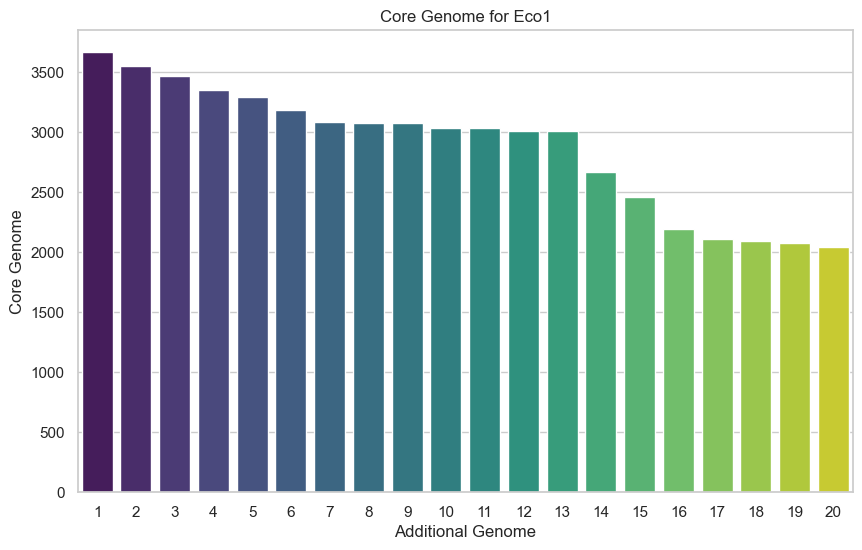

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creazione del grafico a barre
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(range(1, len(lengths_list) + 1)), y=lengths_list, palette="viridis")

# Aggiunta di etichette e titoli
ax.set(xlabel='Additional Genome', ylabel='Core Genome',
       title=f'Core Genome for {prefix_to_search}')
plt.show()


__Iter merging process over each differen genome__

In [9]:
import pandas as pd

def extract_prefixes(result_reciprocal_hits):
    unique_prefixes = []

    for df in result_reciprocal_hits:
        first_row = df.iloc[0]
        prefix = first_row['query_id_file1'].split('_')[0]
        if prefix not in unique_prefixes:
            unique_prefixes.append(prefix)

    return unique_prefixes

def check_prefix_match(result_reciprocal_hits, prefix_to_search):
    matching_dataframes = []

    for df in result_reciprocal_hits:
        first_row = df.iloc[0]
        prefix_col1 = first_row['query_id_file1'].split('_')[0]

        if prefix_col1 == prefix_to_search:
            matching_dataframes.append(df)
            continue

        prefix_col2 = first_row['subject_id_file1'].split('_')[0]

        if prefix_col2 == prefix_to_search:
            matching_dataframes.append(df)

    return matching_dataframes

def merge_on_prefix(dataframes_list, prefix_to_search):
    if len(dataframes_list) < 2:
        raise ValueError("At least two dataframes are required for merging.")

    result_lengths = [len(dataframes_list[0])]     
        
    result_df = pd.merge(dataframes_list[0], dataframes_list[1], left_on=find_column_with_string(dataframes_list[0], prefix_to_search), right_on=find_column_with_string(dataframes_list[1], prefix_to_search), how='inner', suffixes=('_left', '_right'))
    
    #result_lengths = [len(result_df)]  # Salva la lunghezza del primo merge
    result_lengths.append(len(result_df))
    
    for i in range(2, len(dataframes_list)):
        column_to_mergeL = find_column_with_string(result_df, prefix_to_search)
        column_to_mergeR = find_column_with_string(dataframes_list[i], prefix_to_search)
        merged_df = pd.merge(result_df, dataframes_list[i], left_on=column_to_mergeL, right_on=column_to_mergeR, how='inner', suffixes=(f'_left_{i}', f'_right_{i}'))
        result_lengths.append(len(merged_df))  # Salva la lunghezza del merge corrente
        result_df = merged_df

    return result_df, result_lengths

unique_prefixes_list = extract_prefixes(result_reciprocal_hits)

all_lengths_lists = {}

for prefix_to_search in unique_prefixes_list:
    matching_dataframes_list = check_prefix_match(result_reciprocal_hits, prefix_to_search)
    result, lengths_list = merge_on_prefix(matching_dataframes_list, prefix_to_search)
    all_lengths_lists[prefix_to_search] = lengths_list

# Stampa le lunghezze per ogni prefisso
for prefix, lengths_list in all_lengths_lists.items():
    print(f"Prefix: {prefix}, Lengths List: {lengths_list}")


Prefix: Eco1, Lengths List: [3665, 3552, 3469, 3349, 3294, 3186, 3085, 3077, 3073, 3037, 3035, 3013, 3009, 2666, 2463, 2189, 2107, 2092, 2077, 2042]
Prefix: Eco2, Lengths List: [3665, 3555, 3469, 3345, 3284, 3176, 3074, 3066, 3062, 3035, 3034, 3013, 3009, 2665, 2465, 2191, 2110, 2094, 2079, 2045]
Prefix: Eco3, Lengths List: [4021, 3558, 3472, 3352, 3290, 3184, 3082, 3074, 3069, 3038, 3036, 3014, 3010, 2665, 2465, 2194, 2110, 2095, 2081, 2047]
Prefix: Eco4, Lengths List: [4108, 3542, 3463, 3342, 3286, 3179, 3076, 3068, 3063, 3034, 3032, 3011, 3007, 2663, 2458, 2186, 2106, 2091, 2076, 2042]
Prefix: Eco5, Lengths List: [3847, 3466, 3422, 3348, 3291, 3184, 3080, 3072, 3068, 3037, 3035, 3013, 3009, 2665, 2465, 2192, 2113, 2097, 2082, 2046]
Prefix: Eco6, Lengths List: [3577, 3512, 3441, 3370, 3287, 3179, 3078, 3070, 3065, 3035, 3034, 3012, 3008, 2665, 2462, 2189, 2107, 2092, 2077, 2043]
Prefix: Eco7, Lengths List: [3718, 3439, 3380, 3318, 3226, 3182, 3080, 3072, 3067, 3039, 3038, 3016, 3012,

__Plot results averaging between different Genomes used as starting point__

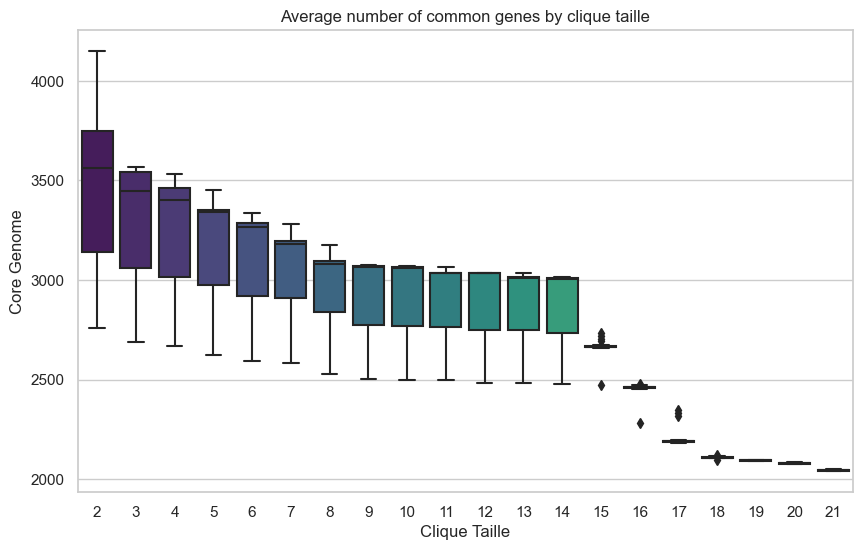

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Creazione del boxplot con seaborn
data = []

for prefix, lengths_list in all_lengths_lists.items():
    for i, length in enumerate(lengths_list, start=2):  # Parti da 2 invece di 1
        data.append({'Merge Step': i, 'Core Genome': length})

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Merge Step', y='Core Genome', data=df, palette='viridis')

# Aggiunta di etichette e titoli
plt.xlabel('Clique Taille')
plt.ylabel('Core Genome')
plt.title('Average number of common genes by clique taille')
plt.show()
